In [2]:
SRC_FOLDER = 'dataset/data/'
DST_TRAINING_FOLDER = 'dataset/training/'
DST_TEST_FOLDER = 'dataset/test/'
YOLO_FOLDERS = ['images', 'labels']
MODELS = ['det', 'seg', 'pose']
CONFIG_YAML_FOLDER = 'dataset/training/config_yamls'

K_FOLD = 4
TRAINING_SIZE = 3000

import os
import shutil
import json
from PIL import Image
import random
import yaml


# Folders for training and validation sets (DST_TRAINING_FOLDER + YOLO_FOLDERS + [f'fold_{i}' for i in range(K_FOLD)])


FOLDERS = [
        os.path.join(DST_TRAINING_FOLDER, 'images', f'fold_{i}') for i in range(K_FOLD)
    ] + [
        os.path.join(DST_TRAINING_FOLDER, model, f'fold_{i}', f) for i in range(K_FOLD) for model in MODELS for f in YOLO_FOLDERS
    ] + [
        os.path.join(DST_TEST_FOLDER, 'images'),
        os.path.join(CONFIG_YAML_FOLDER)
    ] + [
        os.path.join(DST_TEST_FOLDER, model, YOLO_FOLDERS[1]) for model in MODELS
    ] + [
        os.path.join(DST_TEST_FOLDER, 'correct_output')
    ]


# Get all json files in the source folder
json_files = [f for f in os.listdir(SRC_FOLDER) if f.endswith('.json')]

# Shuffle the files to split them into sets randomly (seed for reproducibility)
random.seed(42)
random.shuffle(json_files)

# Empty destination folder and create necessary subfolders
for folder in FOLDERS:
    if os.path.exists(folder):
        if os.path.islink(folder):
            os.unlink(folder)
        elif os.path.isdir(folder):
            shutil.rmtree(folder)
        else:
            os.remove(folder)
    os.makedirs(folder, exist_ok=True)

classes = {
    'B': 0, 'K': 1, 'N': 2, 'P': 3, 'Q': 4, 'R': 5,
    'b': 6, 'k': 7, 'n': 8, 'p': 9, 'q': 10, 'r': 11
}

i = 0
for file in json_files:

    # get the corresponding image file
    image_file = file.replace('.json', '.png')
    if not os.path.exists(os.path.join(SRC_FOLDER, image_file)):
        print(f"Image file {image_file} not found for {file}, skipping.")
        continue

    
    # Determine if this file should go to the test set or training set
    if i < TRAINING_SIZE:
        # Training/validation sets
        fold_index = i % K_FOLD
        image_folder = os.path.join(DST_TRAINING_FOLDER, 'images', f'fold_{fold_index}')
        label_folder_det = os.path.join(DST_TRAINING_FOLDER, MODELS[0], f'fold_{fold_index}', YOLO_FOLDERS[1])
        label_folder_seg = os.path.join(DST_TRAINING_FOLDER, MODELS[1], f'fold_{fold_index}', YOLO_FOLDERS[1])
        label_folder_pose = os.path.join(DST_TRAINING_FOLDER, MODELS[2], f'fold_{fold_index}', YOLO_FOLDERS[1])

                                                                                                                     
    else:
        # Test set
        image_folder = os.path.join(DST_TEST_FOLDER, 'images')
        label_folder_det = os.path.join(DST_TEST_FOLDER, MODELS[0], YOLO_FOLDERS[1])
        label_folder_seg = os.path.join(DST_TEST_FOLDER, MODELS[1], YOLO_FOLDERS[1])
        label_folder_pose = os.path.join(DST_TEST_FOLDER, MODELS[2], YOLO_FOLDERS[1])
        shutil.copy(os.path.join(SRC_FOLDER, file), os.path.join(os.path.join(DST_TEST_FOLDER, 'correct_output'), file))

    # Remove trailing slash if present for each label folder
    if label_folder_det[-1] == '/':
        label_folder_det = label_folder_det[:-1]
    if label_folder_seg[-1] == '/':
        label_folder_seg = label_folder_seg[:-1]
    if label_folder_pose[-1] == '/':
        label_folder_pose = label_folder_pose[:-1]

    shutil.copy(os.path.join(SRC_FOLDER, image_file), os.path.join(image_folder, image_file))

    # Get the height and width of the image
    image_path = os.path.join(SRC_FOLDER, image_file)
    with Image.open(image_path) as img:
        width, height = img.size
    
    # Read the json file and load the data
    with open(os.path.join(SRC_FOLDER, file), 'r') as f:
        data = json.load(f)
    

    ###################################################
    # Create the label file for pieces bounding boxes #
    ###################################################
    bbox_output = ''
    for item in data['pieces']:
        class_name = item['piece']
        
        box = item['box']
        bbox_output += f"{classes[class_name]} {(box[0] + box[2] / 2)/width} {(box[1] + box[3] / 2)/height} {box[2] / width} {box[3] / height}\n"

    label_file = file.replace('.json', '.txt')
    with open(os.path.join(label_folder_det, label_file), 'w') as f:
        f.write(bbox_output.strip())
    

    ######################################################
    # Create the label file for board segmentation masks #
    ######################################################
    corners = data['corners']
    
    output = f"0 {corners[0][0] / width} {corners[0][1] / height} {corners[1][0] / width} {corners[1][1] / height} {corners[2][0] / width} {corners[2][1] / height} {corners[3][0] / width} {corners[3][1] / height}\n"
    with open(os.path.join(label_folder_seg, label_file), 'w') as f:
        f.write(output.strip())


    ############################################
    # Create the label file for pose keypoints #
    ############################################
    x_coords = [pt[0] for pt in corners]
    y_coords = [pt[1] for pt in corners]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    corners_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    
    output = f"0 {(corners_bbox[0] + corners_bbox[2] / 2) / width} {(corners_bbox[1] + corners_bbox[3] / 2) / height} {corners_bbox[2] / width} {corners_bbox[3] / height} {corners[0][0] / width} {corners[0][1] / height} {corners[1][0] / width} {corners[1][1] / height} {corners[2][0] / width} {corners[2][1] / height} {corners[3][0] / width} {corners[3][1] / height}\n"
    
    with open(os.path.join(label_folder_pose, label_file), 'w') as f:
        f.write(output.strip())


    i += 1
    if i % 100 == 0:
        print(f"Processed {i} files")

# Create the config YAML files for each fold
for fold_index in range(K_FOLD):
    # Detection config
    config_yaml = {
        'path' : os.path.join(DST_TRAINING_FOLDER, MODELS[0]),
        'train': [f'fold_{i}' for i in range(K_FOLD) if i != fold_index],
        'val': f'fold_{fold_index}',
        'nc': len(classes),
        'names': {v: k for k, v in classes.items()},
    }
    
    with open(os.path.join(CONFIG_YAML_FOLDER, f'fold_{fold_index}_{MODELS[0]}.yaml'), 'w') as yaml_file:
        yaml.dump(config_yaml, yaml_file)
    
    # Segmentation config
    config_yaml = {
        'path' : os.path.join(DST_TRAINING_FOLDER, MODELS[1]),
        'train': [f'fold_{i}' for i in range(K_FOLD) if i != fold_index],
        'val': f'fold_{fold_index}',
        'nc': 1,  # Only one class for the board
        'names': {0: 'board'},
    }
    with open(os.path.join(CONFIG_YAML_FOLDER, f'fold_{fold_index}_{MODELS[1]}.yaml'), 'w') as yaml_file:
        yaml.dump(config_yaml, yaml_file)

    # Pose config
    config_yaml = {
        'path' : os.path.join(DST_TRAINING_FOLDER, MODELS[2]),
        'train': [f'fold_{i}' for i in range(K_FOLD) if i != fold_index],
        'val': f'fold_{fold_index}',
        'kpt_shape': [4,2],  # 4 keypoints with x, y coordinates
        'nc': 1,  # Only one class for the board
        'names': {0: 'board'}
    }
    with open(os.path.join(CONFIG_YAML_FOLDER, f'fold_{fold_index}_{MODELS[2]}.yaml'), 'w') as yaml_file:
        yaml.dump(config_yaml, yaml_file)

# Create symlink from images_{det, seg, pose} to images
for model in MODELS:
    for k in range(K_FOLD):
        src = os.path.abspath(os.path.join(DST_TRAINING_FOLDER, 'images', f'fold_{k}'))
        dst = os.path.abspath(os.path.join(DST_TRAINING_FOLDER, model, f'fold_{k}', YOLO_FOLDERS[0]))
        # Remove if already exists (file or symlink)
        if os.path.islink(dst) or os.path.exists(dst):
            if os.path.isdir(dst) and not os.path.islink(dst):
                shutil.rmtree(dst)
            else:
                os.unlink(dst)
        os.symlink(src, dst)
    
    # Create symlink for test images
    src = os.path.abspath(os.path.join(DST_TEST_FOLDER, 'images'))
    dst = os.path.abspath(os.path.join(DST_TEST_FOLDER, model, YOLO_FOLDERS[0]))
    # Remove if already exists (file or symlink)
    if os.path.islink(dst) or os.path.exists(dst):
        if os.path.isdir(dst) and not os.path.islink(dst):
            shutil.rmtree(dst)
        else:
            os.unlink(dst)
    os.symlink(src, dst)


# Print summary of the dataset preparation
print(f"Total number of JSON files processed: {len(json_files)}")
print(f"Processed {i} images in total.")
print("Dataset preparation completed successfully.")

# Training and test folder structure
training_image_folders = [os.path.join(DST_TRAINING_FOLDER, 'images', f'fold_{i}') for i in range(K_FOLD)]
test_image_folder = os.path.join(DST_TEST_FOLDER, 'images')

print(f"Training image folders: {training_image_folders}")
print(f"Test image folder: {test_image_folder}")
print(f"Config YAML folder: {CONFIG_YAML_FOLDER}")
print(f"Correct output folder: {os.path.join(DST_TEST_FOLDER, 'correct_output')}")
print(f"Classes: {classes}")
print(f"Total number of classes: {len(classes)}")
print(f"Number of folds: {K_FOLD}")
print(f"Training size: {TRAINING_SIZE}")
print(f"Test size: {len(json_files) - TRAINING_SIZE}")

def count_images_in_folders(folders):
    total_images = 0
    image_counts = {}
    
    for folder in folders:
        count = len([f for f in os.listdir(folder) if f.endswith('.png')])
        image_counts[folder] = count
        total_images += count
    
    return total_images, image_counts

total_train_images, train_image_counts = count_images_in_folders(training_image_folders)
total_test_images, test_image_counts = count_images_in_folders([test_image_folder])
print(f"Total training images: {total_train_images}")
print(f"Training image counts per fold: {train_image_counts}")
print(f"Total test images: {total_test_images}")
print(f"Test image counts: {test_image_counts}")



Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files
Processed 1000 files
Processed 1100 files
Processed 1200 files
Processed 1300 files
Processed 1400 files
Processed 1500 files
Processed 1600 files
Processed 1700 files
Processed 1800 files
Processed 1900 files
Processed 2000 files
Processed 2100 files
Processed 2200 files
Processed 2300 files
Processed 2400 files
Processed 2500 files
Processed 2600 files
Processed 2700 files
Processed 2800 files
Processed 2900 files
Processed 3000 files
Processed 3100 files
Processed 3200 files
Processed 3300 files
Processed 3400 files
Processed 3500 files
Processed 3600 files
Processed 3700 files
Processed 3800 files
Processed 3900 files
Processed 4000 files
Processed 4100 files
Processed 4200 files
Processed 4300 files
Processed 4400 files
Processed 4500 files
Processed 4600 files
Processed 4700 files
Processed 4800 files
T

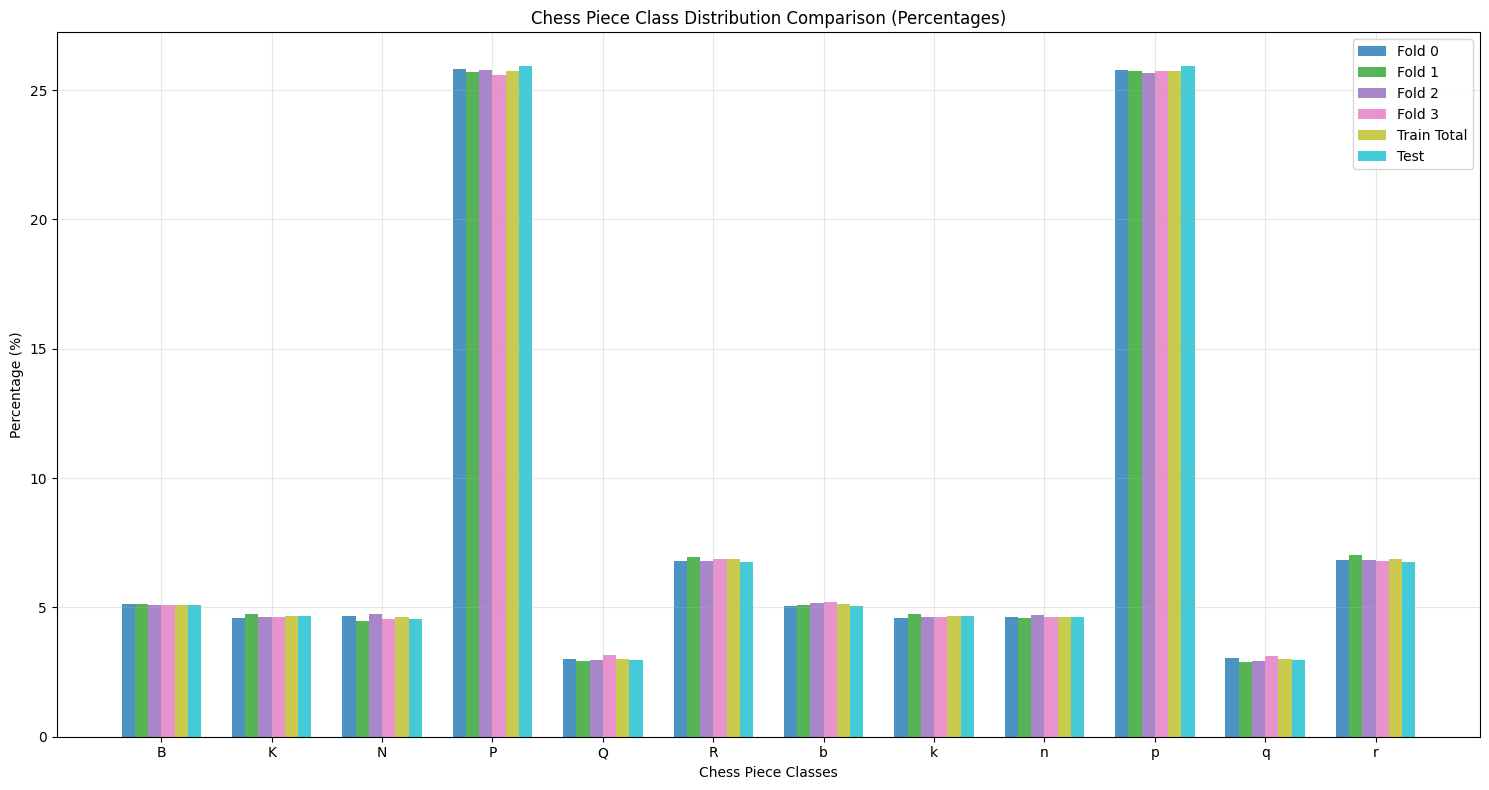


Percentage distribution summary:
Class   Fold 0      Fold 1      Fold 2      Fold 3      Train Total Test        
B       5.11        5.12        5.08        5.11        5.11        5.10        
K       4.60        4.73        4.65        4.63        4.65        4.67        
N       4.69        4.47        4.76        4.55        4.62        4.55        
P       25.83       25.70       25.77       25.58       25.72       25.93       
Q       3.02        2.92        2.97        3.14        3.02        2.98        
R       6.80        6.96        6.81        6.88        6.86        6.76        
b       5.05        5.11        5.18        5.19        5.13        5.05        
k       4.60        4.73        4.65        4.63        4.65        4.67        
n       4.63        4.58        4.71        4.62        4.64        4.62        
p       25.79       25.75       25.66       25.73       25.74       25.94       
q       3.05        2.89        2.94        3.11        3.00        2.97   

In [4]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Prepare counters
fold_class_counts = [Counter() for _ in range(K_FOLD)]
test_class_counts = Counter()
train_class_counts = Counter()

for idx, file in enumerate(json_files):
    # Determine if this file is in train or test set
    if idx < TRAINING_SIZE:
        fold_index = idx % K_FOLD
        set_counter = fold_class_counts[fold_index]
        train = True
    else:
        set_counter = test_class_counts
        train = False

    # Read the json file and count pieces
    with open(os.path.join(SRC_FOLDER, file), 'r') as f:
        data = json.load(f)
    for item in data['pieces']:
        class_name = item['piece']
        set_counter[class_name] += 1
        if train:
            train_class_counts[class_name] += 1

# Calculate percentages and create comparison plot
labels = sorted(classes.keys(), key=lambda k: classes[k])

# Calculate total counts for percentage calculation
fold_totals = [sum(counter.values()) for counter in fold_class_counts]
train_total = sum(train_class_counts.values())
test_total = sum(test_class_counts.values())

# Create percentage data
percentage_data = []
group_labels = []

# Add fold percentages
for i, (fold_counter, total) in enumerate(zip(fold_class_counts, fold_totals)):
    percentages = [fold_counter.get(label, 0) / total * 100 if total > 0 else 0 for label in labels]
    percentage_data.append(percentages)
    group_labels.append(f'Fold {i}')

# Add train total percentage
train_percentages = [train_class_counts.get(label, 0) / train_total * 100 if train_total > 0 else 0 for label in labels]
percentage_data.append(train_percentages)
group_labels.append('Train Total')

# Add test percentage
test_percentages = [test_class_counts.get(label, 0) / test_total * 100 if test_total > 0 else 0 for label in labels]
percentage_data.append(test_percentages)
group_labels.append('Test')

# Create grouped bar chart
x = np.arange(len(labels))
width = 0.12  # Width of bars
colors = plt.cm.tab10(np.linspace(0, 1, len(group_labels)))

fig, ax = plt.subplots(figsize=(15, 8))

# Plot bars for each group
for i, (percentages, label, color) in enumerate(zip(percentage_data, group_labels, colors)):
    offset = (i - len(group_labels)/2 + 0.5) * width
    ax.bar(x + offset, percentages, width, label=label, color=color, alpha=0.8)

ax.set_xlabel('Chess Piece Classes')
ax.set_ylabel('Percentage (%)')
ax.set_title('Chess Piece Class Distribution Comparison (Percentages)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plt.savefig('set_distribution_comparison.png')
plt.show()


# Print percentage summary
print("\nPercentage distribution summary:")
print(f"{'Class':<8}", end='')
for label in group_labels:
    print(f"{label:<12}", end='')
print()

for i, piece_class in enumerate(labels):
    print(f"{piece_class:<8}", end='')
    for percentages in percentage_data:
        print(f"{percentages[i]:<12.2f}", end='')
    print()